# Cryptocurrency Market Predictor - Recurrent Neural Network

Predicting BTCUSD market

In [1]:
import tensorflow as tf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Read data

In [2]:
dataset = pd.read_csv('BTCUSD_TechnicalIndicators.csv')
dataset.head(2)

,Price,PriceTarget,MACD,Stochastics,ATR
0,4.33,4.27,-0.108534,0.0,0.13
1,4.27,4.41,-0.129960,0.0,0.06


#### Normalize

In [3]:
datasetNorm = (dataset - dataset.mean()) / (dataset.max() - dataset.min())
datasetNorm.head(2)

,Price,PriceTarget,MACD,Stochastics,ATR
0,-0.108467,-0.108831,-0.002293,-0.59829,-0.044911
1,-0.108480,-0.108803,-0.002345,-0.59829,-0.045010


## Hyperparams

In [4]:
num_epochs = 100

batch_size = 1

total_series_length = len(dataset.index)

truncated_backprop_length = 3 #The size of the sequence

state_size = 12 #The number of neurons

num_features = 4
num_classes = 1 #[1,0]

num_batches = total_series_length//batch_size//truncated_backprop_length

min_test_size = 100

print('The total series length is: %d' %total_series_length)
print('The current configuration gives us %d batches of %d observations each one looking %d steps in the past' 
      %(num_batches,batch_size,truncated_backprop_length))

The total series length is: 2018
The current configuration gives us 672 batches of 1 observations each one looking 3 steps in the past


## Train-Test split

In [5]:
datasetTrain = datasetNorm[dataset.index < num_batches*batch_size*truncated_backprop_length]


for i in range(min_test_size,len(datasetNorm.index)):
    
    if(i % truncated_backprop_length*batch_size == 0):
        test_first_idx = len(datasetNorm.index)-i
        break

datasetTest =  datasetNorm[dataset.index >= test_first_idx]

In [6]:
datasetTrain.head(2)

,Price,PriceTarget,MACD,Stochastics,ATR
0,-0.108467,-0.108831,-0.002293,-0.59829,-0.044911
1,-0.108480,-0.108803,-0.002345,-0.59829,-0.045010


In [7]:
datasetTest.head(2)

,Price,PriceTarget,MACD,Stochastics,ATR
1916,0.428574,0.470544,0.086009,0.40171,0.176425
1917,0.470895,0.429535,0.135373,0.40171,0.343795


In [8]:
xTrain = datasetTrain[['Price','MACD','Stochastics','ATR']].as_matrix()
yTrain = datasetTrain['PriceTarget'].as_matrix()

In [9]:
print(xTrain[0:3],'\n',yTrain[0:3])

[[-0.10846741 -0.00229342 -0.59829008 -0.0449111 ]
 [-0.10847965 -0.0023445  -0.59829008 -0.04500955]
 [-0.10845109 -0.00234725 -0.51292423 -0.04489703]] 
 [-0.10883111 -0.10880255 -0.10884132]


In [10]:
xTest = datasetTest[['Price','MACD','Stochastics','ATR']].as_matrix()
yTest = datasetTest['PriceTarget'].as_matrix()

In [11]:
print(xTest[0:3],'\n',yTest[0:3])

[[ 0.42857439  0.08600864  0.40170992  0.17642505]
 [ 0.47089504  0.13537317  0.40170992  0.34379495]
 [ 0.42988645  0.12731495  0.17105457  0.30624221]] 
 [ 0.47054359  0.42953499  0.45799431]


## Visualize starting price data

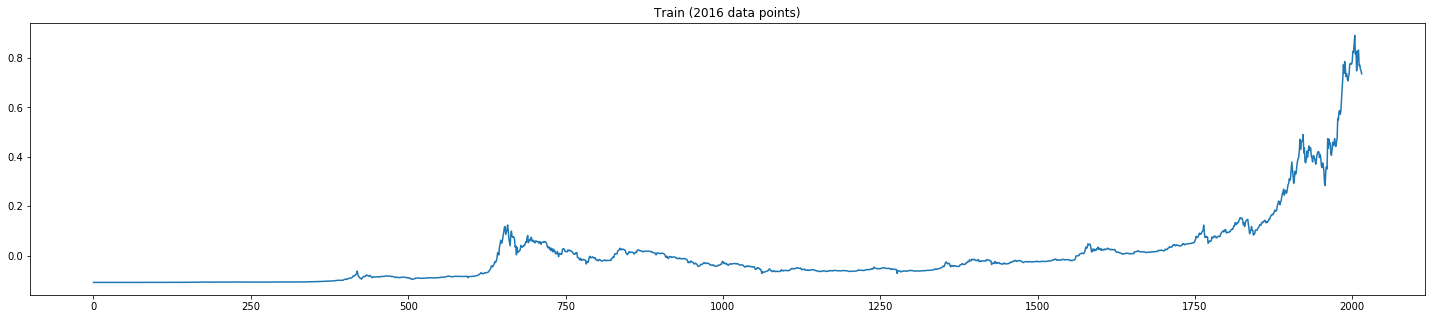

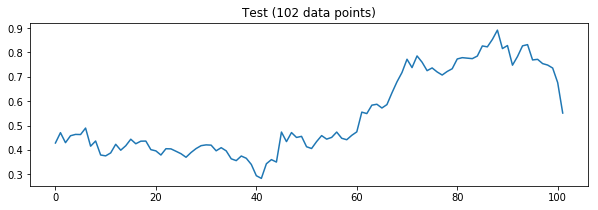

In [12]:
plt.figure(figsize=(25,5))
plt.plot(xTrain[:,0])
plt.title('Train (' +str(len(xTrain))+' data points)')
plt.show()
plt.figure(figsize=(10,3))
plt.plot(xTest[:,0])
plt.title('Test (' +str(len(xTest))+' data points)')
plt.show()

## Placeholders

In [13]:
batchX_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_features],name='data_ph')
batchY_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_classes],name='target_ph')

## Weights and biases
Because is a 3 layer net:
1. Input
2. Hidden Recurrent layer
3. Output

We need 2 pairs of W and b

In [14]:
W2 = tf.Variable(initial_value=np.random.rand(state_size,num_classes),dtype=tf.float32)
b2 = tf.Variable(initial_value=np.random.rand(1,num_classes),dtype=tf.float32)

Unpack

In [15]:
labels_series = tf.unstack(batchY_placeholder, axis=1)

## Forward pass - Unroll the cell

Input to recurrent

In [16]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=state_size)

states_series, current_state = tf.nn.dynamic_rnn(cell=cell,inputs=batchX_placeholder,dtype=tf.float32)

In [17]:
states_series = tf.transpose(states_series,[1,0,2])

## Backward pass - Output

In [18]:
last_state = tf.gather(params=states_series,indices=states_series.get_shape()[0]-1)
last_label = tf.gather(params=labels_series,indices=len(labels_series)-1)

## Weights and bias out

In [19]:
weight = tf.Variable(tf.truncated_normal([state_size,num_classes]))
bias = tf.Variable(tf.constant(0.1,shape=[num_classes]))

## Prediction, Loss & Optimizer

In [20]:
prediction = tf.matmul(last_state,weight) + bias
prediction

<tf.Tensor 'add:0' shape=(?, 1) dtype=float32>

In [21]:
loss = tf.reduce_mean(tf.squared_difference(last_label,prediction))

train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [22]:
loss_list = []
test_pred_list = []

with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    
    for epoch_idx in range(num_epochs):
                
        print('Epoch %d' %epoch_idx)
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length * batch_size
        
            
            batchX = xTrain[start_idx:end_idx,:].reshape(batch_size,truncated_backprop_length,num_features)
            batchY = yTrain[start_idx:end_idx].reshape(batch_size,truncated_backprop_length,1)
                
            #print('IDXs',start_idx,end_idx)
            #print('X',batchX.shape,batchX)
            #print('Y',batchX.shape,batchY)
            
            feed = {batchX_placeholder : batchX, batchY_placeholder : batchY}
            
            #TRAIN!
            _loss,_train_step,_pred,_last_label,_prediction = sess.run(
                fetches=[loss,train_step,prediction,last_label,prediction],
                feed_dict = feed
            )
            
            loss_list.append(_loss)
            
           
            
            if(batch_idx % 200 == 0):
                print('Step %d - Loss: %.6f' %(batch_idx,_loss))
                
    #TEST
    
    
    for test_idx in range(len(xTest) - truncated_backprop_length):
        
        testBatchX = xTest[test_idx:test_idx+truncated_backprop_length,:].reshape((1,truncated_backprop_length,num_features))        
        testBatchY = yTest[test_idx:test_idx+truncated_backprop_length].reshape((1,truncated_backprop_length,1))

        
        #_current_state = np.zeros((batch_size,state_size))
        feed = {batchX_placeholder : testBatchX,
            batchY_placeholder : testBatchY}

        #Test_pred contains 'window_size' predictions, we want the last one
        _last_state,_last_label,test_pred = sess.run([last_state,last_label,prediction],feed_dict=feed)
        test_pred_list.append(test_pred[-1][-1]) #The last one

Epoch 0
Step 0 - Loss: 0.000820
Step 200 - Loss: 0.000248
Step 400 - Loss: 0.000031
Step 600 - Loss: 0.003531
Epoch 1
Step 0 - Loss: 0.033682
Step 200 - Loss: 0.000025
Step 400 - Loss: 0.000011
Step 600 - Loss: 0.001539
Epoch 2
Step 0 - Loss: 0.016179
Step 200 - Loss: 0.000001
Step 400 - Loss: 0.000022
Step 600 - Loss: 0.001491
Epoch 3
Step 0 - Loss: 0.006101
Step 200 - Loss: 0.000001
Step 400 - Loss: 0.000004
Step 600 - Loss: 0.000233
Epoch 4
Step 0 - Loss: 0.000047
Step 200 - Loss: 0.000000
Step 400 - Loss: 0.000059
Step 600 - Loss: 0.000139
Epoch 5
Step 0 - Loss: 0.001707
Step 200 - Loss: 0.000003
Step 400 - Loss: 0.000004
Step 600 - Loss: 0.000042
Epoch 6
Step 0 - Loss: 0.001085
Step 200 - Loss: 0.000001
Step 400 - Loss: 0.000023
Step 600 - Loss: 0.000947
Epoch 7
Step 0 - Loss: 0.000153
Step 200 - Loss: 0.000030
Step 400 - Loss: 0.000018
Step 600 - Loss: 0.000000
Epoch 8
Step 0 - Loss: 0.000195
Step 200 - Loss: 0.000004
Step 400 - Loss: 0.000002
Step 600 - Loss: 0.000554
Epoch 9
St

Epoch 74
Step 0 - Loss: 0.000860
Step 200 - Loss: 0.000000
Step 400 - Loss: 0.000026
Step 600 - Loss: 0.000041
Epoch 75
Step 0 - Loss: 0.000861
Step 200 - Loss: 0.000000
Step 400 - Loss: 0.000032
Step 600 - Loss: 0.000054
Epoch 76
Step 0 - Loss: 0.000962
Step 200 - Loss: 0.000000
Step 400 - Loss: 0.000032
Step 600 - Loss: 0.000054
Epoch 77
Step 0 - Loss: 0.000988
Step 200 - Loss: 0.000001
Step 400 - Loss: 0.000023
Step 600 - Loss: 0.000046
Epoch 78
Step 0 - Loss: 0.000522
Step 200 - Loss: 0.000000
Step 400 - Loss: 0.000026
Step 600 - Loss: 0.000035
Epoch 79
Step 0 - Loss: 0.000618
Step 200 - Loss: 0.000000
Step 400 - Loss: 0.000031
Step 600 - Loss: 0.000050
Epoch 80
Step 0 - Loss: 0.000730
Step 200 - Loss: 0.000000
Step 400 - Loss: 0.000032
Step 600 - Loss: 0.000047
Epoch 81
Step 0 - Loss: 0.000918
Step 200 - Loss: 0.000001
Step 400 - Loss: 0.000023
Step 600 - Loss: 0.000037
Epoch 82
Step 0 - Loss: 0.000359
Step 200 - Loss: 0.000000
Step 400 - Loss: 0.000028
Step 600 - Loss: 0.000033
E

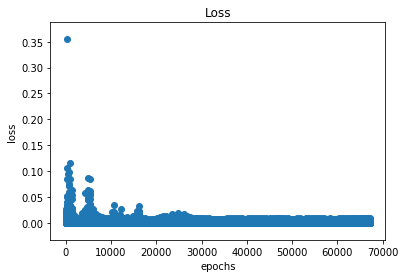

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Loss')
plt.scatter(x=np.arange(0,len(loss_list)),y=loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show();

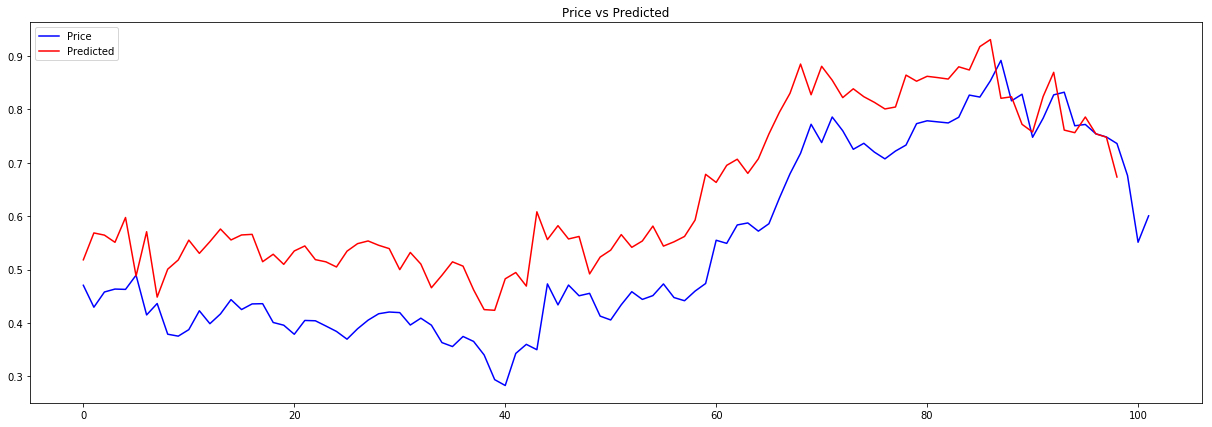

In [24]:
plt.figure(figsize=(21,7))
plt.plot(yTest,label='Price',color='blue')
plt.plot(test_pred_list,label='Predicted',color='red')
plt.title('Price vs Predicted')
plt.legend(loc='upper left')
plt.show()